In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
nlp=spacy.load("en_core_web_lg")
pd.set_option("display.max_rows",None)
nltk.download("vader_lexicon")
nltk.download("punkt")
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [188]:
train=pd.read_csv("Data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [189]:
test=pd.read_csv("Data/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [190]:
print("Null values in training set")
print(train.isnull().sum())
print("Null values in testing set")
print(test.isnull().sum())

Null values in training set
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values in testing set
id             0
keyword       26
location    1105
text           0
dtype: int64


In [191]:
print(train[["keyword","text"]].sample(10))

                keyword                                               text
5700            rescued  Turn back to me! I have rescued you and swept ...
5496         quarantine  Reddit Will Now Quarantine OffensiveåÊContent ...
2205             deluge  I apologise sincerely for the inevitable delug...
723            bleeding       @CoreyAshe Did that look broken or bleeding?
5142  nuclear%20reactor  A little filming inside a Nuclear Reactor at #...
608           bioterror  FedEx no longer to transport bioterror germs i...
943          blown%20up  @KalinAndMyles @KalinWhite my ig is being blow...
5791            rioting  #BHRAMABULL Watch Run The Jewels Use Facts to ...
2796           disaster  DISASTER AVERTED: Police kill gunman with 'hoa...
5255        oil%20spill  Watch our video of Wendell Berry speaking abou...


In [192]:
train_real=train[train["target"]==1]
train_fake=train[train["target"]==0]

In [193]:
print(train_real.shape," is the size of real train dataset")
print(train_fake.shape," is the size of fake train dataset")

(3271, 5)  is the size of real train dataset
(4342, 5)  is the size of fake train dataset


In [194]:
print(train_real["keyword"].nunique(),train_fake["keyword"].nunique())
print(test["keyword"].nunique())
print(set(train.keyword.unique())-set(test.keyword.unique()))

220 218
221
set()


In [195]:
impWords=train["keyword"].unique()[:15]
print(impWords)

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked']


In [196]:
# plt.figure(figsize=(15,10))
# sns.countplot(x=train["keyword"],hue=train["target"])
# plt.xticks(rotation=90)

In [197]:
unique=train["keyword"].unique().astype("str")
unique.tolist()
# uniqueCollection=[unique[i:i+15] 
#                   for i in range(0,len(unique),15)]
# plt.figure(figsize=(10,15))
# subplot_counter=1
# for group in uniqueCollection:
#     plt.figure(figsize=(10,15))
#     plt.subplot(len(uniqueCollection),1,subplot_counter)
#     countplot=sns.countplot(data=train[train["keyword"].isin(group)],x="keyword",hue="target")
#     plt.xticks(rotation=90)
#     plt.legend(title="target",loc="lower left")

['nan',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolat

In [198]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment=SentimentIntensityAnalyzer()

In [199]:
def lastKeyIn(info):
    keyword=info[0]
    text=info[1]
    if pd.notna(keyword):
         return keyword
    doc=nlp(text)
    high_neg=0
    negative_word=None
    for word in doc:
        if word.is_stop or word.is_oov or word.is_space or word.is_punct:
             pass
        elif word.is_ascii:
            if word.text in unique or word.lemma_ in unique:
                return word
            neg=sentiment.polarity_scores(word.text)["neg"]
            if neg>high_neg:
                  high_neg=neg
                  negative_word=word
    if high_neg<0.5:
         return("Others")
    return negative_word.lower

In [200]:
print(train.isnull().sum())
train.keyword=train[["keyword","text"]].apply(lastKeyIn,axis=1)
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword        0
location    2533
text           0
target         0
dtype: int64


In [201]:
keyword=train.keyword.unique().astype("str")
keyword=keyword.tolist()
keyword=set(keyword)
keyword

{'10595077177392105327',
 '1228720749737493560',
 '13773067740709375554',
 '14012806951969610844',
 '1523267725910686442',
 '7886921362353864828',
 '920492170430266568',
 'CYCLONE',
 'Damage',
 'Earthquake',
 'Evacuation',
 'FIRE',
 'Others',
 'Seismic',
 'Thunderstorm',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'colli

In [202]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [203]:
countries=train.location.unique().tolist()
print(len(countries))

3342


In [204]:
print(countries[1:10])

['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'New York'),
  Text(2, 0, 'United States'),
  Text(3, 0, 'London'),
  Text(4, 0, 'Canada'),
  Text(5, 0, 'Nigeria'),
  Text(6, 0, 'UK'),
  Text(7, 0, 'Los Angeles, CA'),
  Text(8, 0, 'India'),
  Text(9, 0, 'Mumbai'),
  Text(10, 0, 'Washington, DC'),
  Text(11, 0, 'Kenya'),
  Text(12, 0, 'Worldwide'),
  Text(13, 0, 'Australia'),
  Text(14, 0, 'Chicago, IL')])

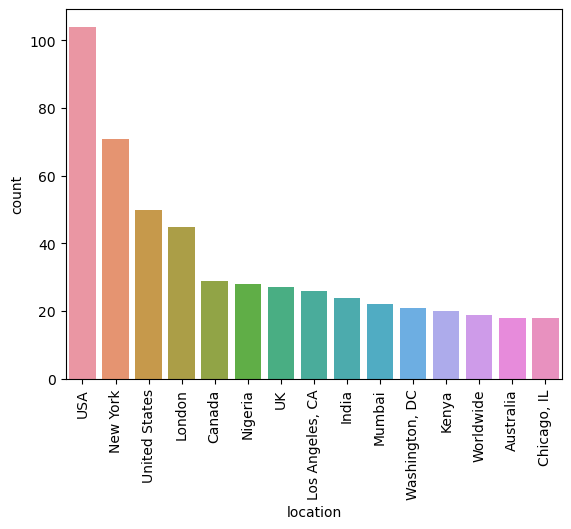

In [205]:
sns.countplot(x=train["location"],order=train.location.value_counts().iloc[:15].index)
plt.xticks(rotation=90)

In [206]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [207]:
text_to_train=train.text[3]

In [208]:
def location(cols):
    location=cols[0]
    text=cols[1]
    if pd.notna(location):
        return location
    text=nlp(text)
    for word in text.ents :
        if word.label_ in ["GPE","LOC"]:
            return word.text
    return "Others"

In [209]:
train["location"]=train[["location","text"]].apply(location,axis=1)

In [210]:
def cleanLocation(x):
    if x == 'Others':
        return 'Others'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    else:
        return x

In [211]:
train["location"]=train["location"].apply(cleanLocation)

In [212]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1


In [213]:
location=train.location.unique().tolist()

In [214]:
len(location)

3026

In [215]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [216]:
# def extractInformation(text):
#     hashWords=[]
#     hash_seq="#(\w+)"
#     hash_count=0
#     text=re.findall(hash_seq,text)
#     for word in text:
#         hash_count+=1  
#         hashWords.append(str(word))
#     return hashWords
# hashtagWords=extractInformation("Hi this is a beatuiful morning #hot #sunny")

In [217]:
def extractInformation(text):
    hash_seq="#(\w+)"
    text=re.findall(hash_seq,text)
    if text==[]:
        return []
    return text
hashtagWords=extractInformation("Hi this is a beatuiful morning hot sunny")

In [218]:
def hashMod(text):
    words=[]
    for word in text:
        if word in keyword:
            words.append(word)
    if words is not []:
        return words
    if text==[]:
        return("None")
    if words is []:
        return text
    

In [219]:
train["HashtagWords"]=train["text"].apply(extractInformation)
train["HashtagWords"]=train["HashtagWords"].apply(hashMod)
train["HashTagSum"]=train["HashtagWords"].apply(lambda x:len(x))

In [220]:
def joinKeywords(text):
    return " ".join(text)
train["HashtagWords"]=train["HashtagWords"].apply(joinKeywords)

In [221]:
# x=train[train["target"]==1]["text"].apply(len)
# y=train[train["target"]==0]["text"].apply(len)
# print("Average length of real tweets are ",np.average(x),"\n Average length of fake tweets are ",np.average(y))

In [222]:
def mentionSearch(text):
    pattern="@(\w+)"
    text=re.findall(pattern,text)
    if text==[]:
        return ("None")
    return " ".join(text)
train["mention"]=train["text"].apply(mentionSearch)
# train["mention"].value_counts()

In [223]:
def sentimentInput(text):
    scores=sentiment.polarity_scores(text)
    return pd.Series([scores["neg"],scores["pos"],scores["neu"],scores["compound"]])
    # train["Negative"]=sentiment.polarity_scores(text)["neg"]
    # train["Neutral"]=sentiment.polarity_scores(text)["neu"]
    # train["Positive"]=sentiment.polarity_scores(text)["pos"]
    # train["Comp"]=sentiment.polarity_scores(text)["compound"]
train[["Negative","Neutral","Positive","Comp"]]=train["text"].apply(sentimentInput)

In [224]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp
7033,10079,typhoon,Taiwan,nbanews Soudelor Typhoon Soudelor is taking de...,1,,0,None,0.170,0.000,0.830,-0.6486
4447,6329,hostage,Sydney,Sydney hostage crisis has now been recovered f...,1,,0,None,0.291,0.000,0.709,-0.6249
962,1391,body%20bag,Others,New Ladies Shoulder Tote Handbag Women Cross B...,0,,0,None,0.000,0.000,1.000,0.0000
5877,8394,sandstorm,Others,Watch This Airport Get Swallowed Up By A Sands...,1,,0,None,0.000,0.000,1.000,0.0000
2988,4295,drowning,Ns,@Homukami Only URs and SRs matter Rs you'll be...,0,,0,Homukami,0.000,0.196,0.804,0.4404
7288,10429,whirlwind,cantwaittoplayinminneapolis,Whirlwind weekend #1 starts in 12 hours #cantw...,0,,0,None,0.000,0.000,1.000,0.0000
1023,1485,body%20bags,WESTSIDE OF PHILLY 7? BLOCK??,Ain't no bags in the trunk it's a body,0,,0,None,0.000,0.212,0.788,0.2235
7232,10358,weapons,Ukraine,Ukraine argues for US weapons during Pelosi's ...,1,,0,None,0.355,0.000,0.645,-0.6705
1531,2213,chemical%20emergency,Ukraine and Ireland,Russian nuclear-biological-chemical (NBC) brig...,1,,0,None,0.191,0.000,0.809,-0.3818
5072,7230,natural%20disaster,America of Founding Fathers,This is the natural and unavoidable consequenc...,0,,0,None,0.000,0.152,0.848,0.3612


In [225]:
train.corr()["target"].drop("target")

id            0.060781
HashTagSum    0.075032
Negative      0.124187
Neutral      -0.206829
Positive      0.030898
Comp         -0.220972
Name: target, dtype: float64

In [226]:
# text="You should less drink water and kill more people and stab them"
# scoresSentiment=sentiment.polarity_scores(text)
# scoresSentiment
# sentimentZero=train[train["SentimentScore"]==0]
# sentimentZero['target'].value_counts()
# sentimentNotZero=train[train["SentimentScore"]!=0]
# sentimentNotZero["target"].value_counts()
# sentimentGreaterThan5=(train["SentimentScore"]>0.25).sum()

In [227]:
train["HashtagWords"]=train["HashtagWords"].replace("","None")

In [228]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,0.851,0.2732
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,0.714,-0.3400
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,0.905,-0.2960
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,1.000,0.0000
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,1.000,0.0000


In [229]:
train["HashtagWords"].unique()

array(['earthquake', 'None', 'wildfires', 'flood disaster', 'flooding',
       'aftershock', 'accident', 'ambulance', 'apocalypse', 'armageddon',
       'bioterrorism', 'bombed', 'wildfire', 'casualties', 'catastrophe',
       'danger', 'dead', 'tragedy crash', 'floods', 'deluge',
       'demolished', 'survived', 'destruction', 'disaster', 'displaced',
       'drought', 'bomb', 'Earthquake', 'fire emergency rescue sirens',
       'evacuate', 'evacuation', 'fire', 'floods flooding', 'hailstorm',
       'hail hailstorm', 'hostages terrorism', 'terrorism', 'hurricane',
       'sinkhole landslide avalanche', 'landslide', 'lava', 'military',
       'disaster mudslide', 'mudslide', 'refugees', 'obliteration',
       'police', 'emergency', 'rainstorm landslide', 'drought wildfires',
       'rescued', 'seismic', 'sinkhole', 'sinking', 'storm', 'thunder',
       'Thunderstorm', 'thunder lightning thunderstorm', 'trauma',
       'survivors', 'traumatised', 'tsunami', 'whirlwind', 'fires',
      

In [230]:
def urlSearch(text):
    pattern=r"https?://t\.co/\S+"
    urls=re.findall(pattern,text)
    if urls:
        return " ".join(urls)
    else:
        return False
    

In [231]:
sample=urlSearch("Hi follow this url https://t.co/7MLMsUzV1Z")
sample

'https://t.co/7MLMsUzV1Z'

In [232]:
train["UrlCount"]=train["text"].apply(urlSearch)

In [233]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount
6970,9998,tsunami,Others,@Kamunt Holy crap it's been forever since I sa...,0,None,0,Kamunt,0.067,0.264,0.670,0.7418,False
1759,2531,collision,USA,Anti Collision Rear- #innovation #gadgets http...,0,None,0,None,0.545,0.000,0.455,-0.5859,http://t.co/SXQTydUvUL
3608,5150,fatal,Play For Ryan ??,fatal attraction,0,None,0,None,0.538,0.462,0.000,-0.1280,False
1338,1935,burning%20buildings,y/e/l,THIS SOUNDS LIKE A SONG YOU WOULD HEAR IN A MO...,0,None,0,None,0.143,0.100,0.757,-0.2732,False
6528,9338,survive,death star,If I survive I'll see you tomorrow,0,None,0,None,0.000,0.000,1.000,0.0000,False
3079,4416,electrocute,Others,@danisnotonfire don't let Phil help out he'll ...,0,None,0,danisnotonfire,0.201,0.000,0.799,-0.3089,False
4335,6156,hijack,Others,Criminals Who Hijack Lorries And Buses Arreste...,1,None,0,Music212,0.298,0.000,0.702,-0.7783,http://t.co/FfKcj8pfj2
2695,3866,detonation,http://t.co/OdMx36WDhM,Ignition Knock (Detonation) Sensor-Senso BECK/...,1,None,0,None,0.000,0.000,1.000,0.0000,http://t.co/OdMx36WDhM http://t.co/gAHeUjRUJu
4208,5979,hazard,Others,@LondonFire Hi ..Is there an email that people...,1,None,0,LondonFire,0.124,0.000,0.876,-0.3400,False
2332,3356,demolition,Others,@DavidVonderhaar if you loved me even a little...,0,None,0,DavidVonderhaar,0.000,0.262,0.738,0.5994,False


In [234]:
def clean_text(text):
    pattern1=r"https?://t\.co/\S+"
    pattern2=r"\d+"
    pattern3=r"@\w+"
    text=re.sub(pattern1,"",text)
    text=re.sub(pattern2,"",text)
    text=re.sub(pattern3,"",text)
    return text.strip()
clean_text("Hi this si a https://t.co/7MLMsUzV1Z 8980098 @return")

'Hi this si a'

In [235]:
train["cleaned_text"]=train["text"].apply(clean_text)

In [236]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,0.851,0.2732,False,Our Deeds are the Reason of this #earthquake M...
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,0.714,-0.3400,False,Forest fire near La Ronge Sask. Canada
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,0.905,-0.2960,False,All residents asked to 'shelter in place' are ...
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,1.000,0.0000,False,", people receive #wildfires evacuation orders ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,1.000,0.0000,False,Just got sent this photo from Ruby #Alaska as ...


In [237]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def grams(text):
    n=3
    text=word_tokenize(text)
    ngramsText=ngrams(text,n)
    return [" ".join(words) for words in ngramsText]

In [238]:
train["Trigrams"]=train["text"].apply(grams)

In [239]:
train.sample(5)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text,Trigrams
6850,9818,trauma,Others,@crazyindapeg @VETS78734 completely understand...,0,None,0,crazyindapeg VETS78734,0.286,0.000,0.714,-0.4215,False,completely understandable considering the trau...,"[@ crazyindapeg @, crazyindapeg @ VETS78734, @..."
1658,2395,collapsed,GOT7SupportPH,collapsed the moment i got home last night lol,0,None,0,None,0.193,0.257,0.550,0.1779,False,collapsed the moment i got home last night lol,"[collapsed the moment, the moment i, moment i ..."
6632,9499,terrorist,Pakistan,HereÛªs how media in Pakistan covered the cap...,1,None,0,None,0.281,0.000,0.719,-0.6908,http://t.co/3MtWh0jJns,HereÛªs how media in Pakistan covered the cap...,"[HereÛªs how media, how media in, media in Pa..."
1798,2582,crash,"Kenton, Ohio",@_chelsdelong12 @kendra_leigh13 I'll crash it,1,None,0,_chelsdelong12 kendra_leigh13,0.403,0.000,0.597,-0.4019,False,I'll crash it,"[@ _chelsdelong12 @, _chelsdelong12 @ kendra_l..."
3530,5046,eyewitness,UK,RT patrickjbutler: Excellent damiengayle eyewi...,1,None,0,None,0.088,0.324,0.588,0.7650,http://t.co/pHH1VmLfoo,RT patrickjbutler: Excellent damiengayle eyewi...,"[RT patrickjbutler :, patrickjbutler : Excelle..."


In [240]:
train["Trigrams"]=train["Trigrams"]

In [241]:
text=train["Trigrams"][0]
text

['Our Deeds are',
 'Deeds are the',
 'are the Reason',
 'the Reason of',
 'Reason of this',
 'of this #',
 'this # earthquake',
 '# earthquake May',
 'earthquake May ALLAH',
 'May ALLAH Forgive',
 'ALLAH Forgive us',
 'Forgive us all']

In [242]:
def vectorize(text):
    vectors=[]
    for trigram in text:
        trigram=nlp(trigram)
        vectors.append(trigram.vector)  
    return vectors      

In [243]:
train.corr()["target"].drop("target").sort_values()

Comp         -0.220972
Neutral      -0.206829
Positive      0.030898
id            0.060781
HashTagSum    0.075032
Negative      0.124187
Name: target, dtype: float64

In [244]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text,Trigrams
1882,2703,crushed,Others,Crushed,0,None,0,None,1.000,0.000,0.000,-0.4215,False,Crushed,[]
4231,6009,hazardous,"Muntinlupa City, Philippines",@HearItFromPatty Also pls help us w/ our campa...,0,None,0,HearItFromPatty,0.060,0.171,0.769,0.3818,False,Also pls help us w/ our campaign to warn the p...,"[@ HearItFromPatty Also, HearItFromPatty Also ..."
1862,2676,crush,"Bolivar, MO",When you're girlfriend is completely gorgeous?...,0,None,0,None,0.220,0.000,0.780,-0.4260,https://t.co/ycwAULQz3U,When you're girlfriend is completely gorgeous?...,"[When you 're, you 're girlfriend, 're girlfri..."
5364,7653,panic,World,@JetixRestored Here's Part 2 Of Teamo Supremo ...,0,None,0,JetixRestored YouTube,0.113,0.476,0.411,0.8628,https://t.co/wBLiMlMT2x,Here's Part Of Teamo Supremo Pogo Panic! I Wa...,"[@ JetixRestored Here, JetixRestored Here 's, ..."
6191,8838,sirens,Others,I added a video to a @YouTube playlist http://...,0,None,0,YouTube,0.000,0.000,1.000,0.0000,http://t.co/f2TqMFh1Yb,I added a video to a playlist Cher Lloyd - S...,"[I added a, added a video, a video to, video t..."
38,56,ablaze,Barbados,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,None,0,None,0.000,0.000,1.000,0.0000,http://t.co/wDUEaj8Q4J,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,"[Barbados # Bridgetown, # Bridgetown JAMAICA, ..."
3165,4543,emergency,Newport,@chowtaxis of Newport a big thanks for the eme...,1,None,0,chowtaxis,0.105,0.250,0.645,0.5574,False,of Newport a big thanks for the emergency run ...,"[@ chowtaxis of, chowtaxis of Newport, of Newp..."
6330,9051,structural%20failure,Others,VIDEO: Virgin Galactic crash: Brakes blamed: I...,1,None,0,None,0.362,0.000,0.638,-0.8176,False,VIDEO: Virgin Galactic crash: Brakes blamed: I...,"[VIDEO : Virgin, : Virgin Galactic, Virgin Gal..."
3047,4374,earthquake,New Zealand,GNS sees unnecessary deaths resulting from ear...,1,None,0,None,0.000,0.242,0.758,0.4939,http://t.co/4rYZMzSgDW,GNS sees unnecessary deaths resulting from ear...,"[GNS sees unnecessary, sees unnecessary deaths..."
1954,2813,cyclone,Republic of the Philippines,A new tropical cyclone is forming near Guam.\n...,1,None,0,None,0.000,0.000,1.000,0.0000,False,A new tropical cyclone is forming near Guam.\n...,"[A new tropical, new tropical cyclone, tropica..."


In [245]:
text="hello once again i am here to make work happen and once again i would like to thank you al"
def tags(text):
    text=nlp(text)
    for word in text:
        print(word.text ," ",spacy.explain(word.tag_))

In [246]:
def pos(text):
    text=nlp(text)
    oov=0
    noun=0
    adj=0
    adv=0
    verb=0
    punct=0
    det=0
    part=0
    pronoun=0
    conj=0
    prep=0
    interj=0
    num=0
    propernoun=0
    aux=0
    for word in text:
        if word.pos_ == "NOUN":
            noun+=1
        elif word.is_oov:
            oov+=1
        elif word.pos_ == "ADJ":
            adj+=1
        elif word.pos_ == "ADV":
            adv+=1
        elif word.pos_ == "VERB":
            verb+=1
        elif word.pos_ =="PUNCT":
            punct+=1
        elif word.pos_ =="DET":
            det+=1
        elif word.pos_ =="PART":
            part+=1
        elif word.pos_ =="PRON":
            pronoun+=1
        elif word.pos_ =="CONJ":
            conj+=1
        elif word.pos_ =="PREP":
            prep+=1
        elif word.pos_ =="INTERJ":
            interj+=1
        elif word.pos_ =="NUM":
            num+=1
        elif word.pos_ =="PROPN":
            propernoun+=1
        elif word.pos_ =="AUX":
            aux+=1

    return oov,noun,adj,adv,verb,punct,det,part,pronoun,conj,prep,interj,num,propernoun,aux

In [247]:
# oov,noun,adj,adv,verb,punct,det,part,pronoun,conj,prep,interj,num,propernoun,aux=pos(text)

In [248]:
train[["OutOfVocabulary", "Noun", "Adjective", "Adverb", "Verb", "Punctuation", "Deter", "Part","Pronoun","Conjunction","Prepositions","Interjections","NumericalNumbers","ProperN","Auxialry"]]=train["text"].apply(pos).apply(pd.Series)

In [249]:
train.sample(2)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
2673,3835,detonate,"Sharkatraz/Bindle's Cleft, PA",@AutoAmes everyone hoped we would join ISIS an...,0,None,0,AutoAmes,0.000,0.186,...,0,1,1,2,0,0,0,0,3,2
1698,2453,collide,Texas,You either ride with us or collide with us. It...,0,None,0,None,0.179,0.000,...,2,0,0,7,0,0,0,0,0,1


In [250]:
train["UrlCount"]=train["UrlCount"].apply(lambda x:1 if x!=False else 0)

In [251]:
train.sample(6)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
2703,3877,detonation,Hiroshima,Don't miss Chris #Appy's detonation of the myt...,1,None,0,salon,0.153,0.063,...,1,2,2,1,0,0,0,1,3,1
2771,3983,devastation,Others,70 Years After Atomic Bombs Japan Still Strugg...,1,None,0,None,0.365,0.000,...,2,2,0,0,0,0,0,1,5,0
4950,7054,meltdown,Others,One of these candidates is going to have a Fra...,0,None,0,None,0.158,0.200,...,1,2,1,1,0,0,0,1,3,1
3743,5320,fire,Others,My avi And header combo is fire,0,None,0,None,0.286,0.000,...,0,0,0,1,0,0,0,0,0,1
2487,3570,desolate,"Lahti, Finland",A new favorite: Desolate 2 by r3do https://t.c...,0,None,0,None,0.000,0.300,...,1,1,0,0,0,0,0,1,0,0
6246,8923,snowstorm,"Raleigh, NC",Transportation panel showing a video of a pile...,1,None,0,None,0.412,0.000,...,2,3,0,1,0,0,0,1,1,0


In [252]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
dtype: object

In [253]:
# def clean_signs(text):
#     text=re.sub(r"[^a-zA-Z\s]","",text)
# train["keyword"]=train["keyword"].astype("str").apply(clean_signs)

<AxesSubplot:xlabel='UrlCount', ylabel='count'>

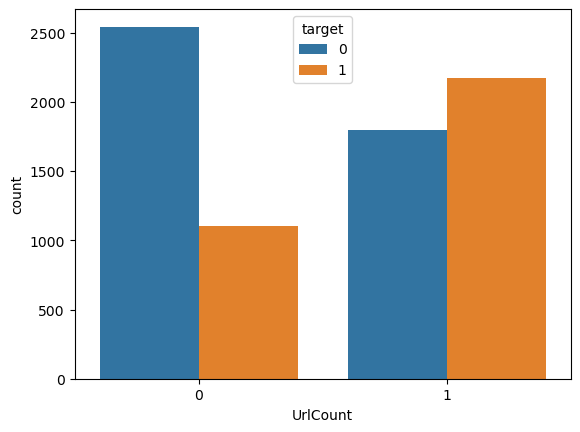

In [254]:
sns.countplot(x="UrlCount",data=train,hue="target")

<AxesSubplot:xlabel='HashTagSum', ylabel='count'>

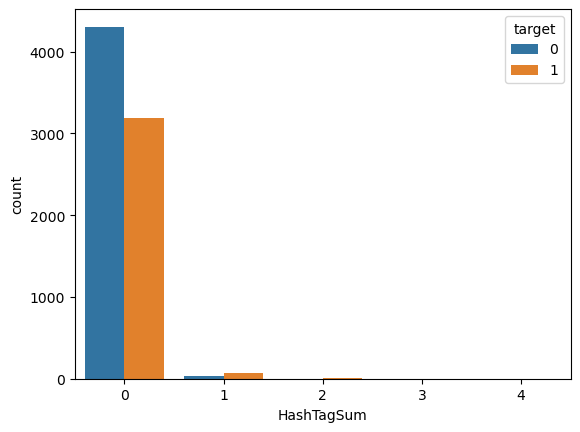

In [255]:
sns.countplot(x="HashTagSum",data=train,hue="target")

In [256]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,...,0,2,0,3,0,0,0,0,1,2
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,...,1,0,0,0,0,0,0,0,5,0
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,...,3,2,1,0,0,0,0,0,0,3
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,...,0,0,0,0,0,0,0,1,1,0
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,...,0,3,0,0,0,0,0,0,3,1


In [257]:
train.corr()["target"].drop("target")

id                  0.060781
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
normVectorize=TfidfVectorizer(analyzer="word")
trivectorize=TfidfVectorizer(ngram_range=(3,3))
CVectorize=CountVectorizer()

In [259]:
# train["text"]=train["text"].apply(lambda x:x.split())
# train["TextTFIDF"]=list(vectorize.fit_transform(train["text"].values).toarray())
# tfidf=tfidf.toarray()
# train["TextTFIDF"]=list(tfidf)
# train["hashVec"]=list(vectorize.fit_transform(train["HashtagWords"]).toarray())
# hashVec=hashVec.toarray()
# train["hastagWordsVec"]=list(hashVec)

In [260]:
# train.head()

In [261]:
trivectorize=TfidfVectorizer(ngram_range=(3,3))
CVectorize=CountVectorizer()
train["TextTFIDF"]=list(normVectorize.fit_transform(train["text"]).toarray())
train["hashVec"]=list(normVectorize.fit_transform(train["HashtagWords"]).toarray())
train["trigramTFIDF"]=list(trivectorize.fit_transform(train["text"]).toarray())
train["locationVec"]=list(CVectorize.fit_transform(train["location"]).toarray())
train["keyword"]=train["keyword"].astype("str")
train["keywordVec"]=list(CVectorize.fit_transform(train["keyword"]).toarray())
# trigramTFIDFarr=trigramTFIDF.toarray()
# train["TrigramsVec"]=list(trigramTFIDFarr)

In [262]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'HashtagWords',
       'HashTagSum', 'mention', 'Negative', 'Neutral', 'Positive', 'Comp',
       'UrlCount', 'cleaned_text', 'Trigrams', 'OutOfVocabulary', 'Noun',
       'Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
       'Pronoun', 'Conjunction', 'Prepositions', 'Interjections',
       'NumericalNumbers', 'ProperN', 'Auxialry', 'TextTFIDF', 'hashVec',
       'trigramTFIDF', 'locationVec', 'keywordVec'],
      dtype='object')

In [263]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,...,0,0,0,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,...,0,0,0,5,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,...,0,0,0,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,...,0,0,1,1,0,"[0.0, 0.41744665140268544, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,...,0,0,0,3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [265]:
locDataFrame=pd.DataFrame(train["location"])

In [266]:
locDataFrame.to_csv("LocValues.csv")

In [269]:
train.corr()["target"]

id                  0.060781
target              1.000000
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [ ]:
from sklearn.pipeline import Pipeline,
from sklearn.preprocessing import StandardScaler
pipeline=Pipeline([
    "Scaler",StandardScaler(),
    "tf-idf-norm",TfidfVectorizer(),
    "tf-idf-tri",TfidfVectorizer(ngram_range=(3,3)),
    "CountVector",CountVectorizer()
])